In [1]:
# import findspark

# findspark.find()
# findspark.init()

from pyspark.sql import SQLContext, SparkSession, DataFrame
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import udf, col, substring, expr, regexp_replace, md5, split, concat_ws, size
from pyspark.sql.types import StringType, BooleanType, ArrayType
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LogisticRegressionModel
from pyspark.ml.feature import NGram, CountVectorizer, CountVectorizerModel
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql.functions import split, col, concat, lit, rand, round
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
import pyspark.sql.functions as fn
from pyspark.sql.types import ArrayType, DoubleType


In [2]:
def _initialize_spark() -> SparkSession:
    """Create a Spark Context for Streamlit app"""

    name = 'Anonymizer for sms texts'
    spark = SparkSession.builder\
        .appName(name)\
        .getOrCreate()
    spark.sparkContext.setLogLevel("WARN")
    return spark


In [3]:
sc = _initialize_spark()

22/07/28 15:03:49 WARN Utils: Your hostname, arcryPC resolves to a loopback address: 127.0.1.1; using 192.168.1.133 instead (on interface wlo1)
22/07/28 15:03:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/07/28 15:03:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/07/28 15:03:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
spark = sc

In [5]:
def standardize_text(df: DataFrame):
    """Удаление лишних символов и коротких слов из текстов"""
    return (
        df.withColumn("text", fn.regexp_replace("text", "ё", "е"))
        .withColumn("text", fn.regexp_replace("text", "[^а-яА-Я-]", " "))
        .withColumn("text", fn.regexp_replace("text", "\W*\b\w{1,3}\b", " "))
        .withColumn("text", fn.regexp_replace("text", " +", " "))
    )

In [6]:
def is_insurance(df: DataFrame, params: dict):
    """Векторизация и классификация текстов"""
    models_path = params["models_path"]
    ngram_builder = PipelineModel.load(models_path + "/ngrams_builder/")
    cnt_vector = CountVectorizerModel.load(models_path + "/count_vectorizer/")
    clf = CrossValidatorModel.load(models_path + "/classifier/")

    df = df.withColumn(
        'tokens', fn.split(fn.col('text'), '')
    )

    df = ngram_builder.transform(
        df
    ).withColumn(
        "features", fn.concat(*[fn.col("{0}_grams".format(i)) for i in range(3, 6)])
    )
    df = cnt_vector.transform(df).select("msisdn", "rawFeatures")
    return clf.transform(df)

In [7]:
def save_temp_table(spark: SparkSession, params: dict):
    table_path = params["table_path"]
    hdfs_path = params["hdfs_tmp_path"]
    df = sc.read.csv(
        table_path, inferSchema=True, header=None
    )
    df.withColumnRenamed(
        "_c0", "text"
    ).withColumn(
        "text", fn.lower(fn.col("text"))
    ).withColumn(
        'msisdn', fn.monotonically_increasing_id()
    ).filter(
        fn.col("text").contains("каско") | fn.col("text").contains("осаго")
    ).coalesce(
        10
    ).write.mode(
        "overwrite"
    ).parquet(
        hdfs_path
    )

In [8]:
def to_array(col):
    def to_array_(v):
        return v.toArray().tolist()
    # Important: asNondeterministic requires Spark 2.3 or later
    # It can be safely removed i.e.
    # return udf(to_array_, ArrayType(DoubleType()))(col)
    # but at the cost of decreased performance
    return udf(to_array_, ArrayType(DoubleType())).asNondeterministic()(col)

In [9]:
params = {'table_path': '../data/raw/500k_sms.csv', 
          'hdfs_tmp_path': '../data/interim/spark_tmp', 
          'result_table_path': '../data/processed/spark_result',
          'models_path': '../models/'}
hdfs_path = params["hdfs_tmp_path"]
result_table_path = params["result_table_path"]

In [339]:
is_insurance(
    standardize_text(
        spark.read.parquet(hdfs_path)
    ), params
).withColumn(
    "probability", vector_to_array(fn.col('probability'))
).withColumn(
    'prediction', fn.when(
        fn.element_at(fn.col('probability'), 1) > 0.55, 0.0  # зададим threshold
    ).otherwise(1.0)
).filter(
    fn.col("prediction") == 1.0
).select(
    "msisdn"
).write.mode(
    "overwrite"
).parquet(
    result_table_path
)

In [340]:
spark.read.parquet(result_table_path).count()

309440

In [104]:
spark.read.csv(
            '../data/interim/data_with_target.csv', header=True, sep='~'
        ).groupBy(col('target')).count().show(50)

+------+------+
|target| count|
+------+------+
|     0| 94413|
|  null|101310|
|     1|314055|
+------+------+



In [108]:
spark.read.csv(
            '../data/interim/data_with_target.csv', header=True, sep='~'
        ).filter('target is not null').count()

408468

In [141]:
is_insurance(
    standardize_text(
        spark.read.csv(
            '../data/interim/data_with_target.csv', header=True, sep='~'
        ).filter(
            'target is not null'
        ).withColumn(
            'msisdn', fn.monotonically_increasing_id()
        ).filter(
        fn.col("text").contains("каско") | fn.col("text").contains("осаго")
        )
    ), params
).write.mode(
    "overwrite"
).parquet(
    '../data/processed/test_res'
)

In [170]:
from pyspark.ml.functions import vector_to_array


In [10]:
df = spark.read.parquet('../data/processed/test_res')
df = df.withColumn("target", df.target.cast('int'))
df = df.withColumn("probability", to_array(col('probability')))
df = df.withColumn('pred', fn.when(fn.element_at(df.probability, 1) > 0.55, 0.0).otherwise(1.0))
df.show()

[Stage 1:>                                                          (0 + 1) / 1]

+-----------+--------------------+------+--------------------+--------------------+--------------------+----------+----+
|     msisdn|         rawFeatures|target|                text|       rawPrediction|         probability|prediction|pred|
+-----------+--------------------+------+--------------------+--------------------+--------------------+----------+----+
|25769803776|(43238,[0,2,3,6,7...|     0| полис осаго ххх ...|[0.94399972444127...|[0.71990687464380...|       0.0| 0.0|
|25769803777|(43238,[0,3,6,8,9...|     1|осаго на ваш зако...|[0.12952148715957...|[0.53233518033844...|       0.0| 1.0|
|25769803778|(43238,[0,3,5,6,7...|     1|вы успешно оформи...|[-1.3300479927903...|[0.20915142675362...|       1.0| 1.0|
|25769803779|(43238,[0,2,3,5,6...|     0| уважаемый клиент...|[0.80038276989827...|[0.69005635336592...|       0.0| 0.0|
|25769803780|(43238,[0,3,6,8,9...|     1|осаго на ваш зако...|[0.12952148715957...|[0.53233518033844...|       0.0| 1.0|
|25769803781|(43238,[0,3,5,6,7..

In [17]:
df

DataFrame[msisdn: bigint, rawFeatures: vector, target: int, text: string, rawPrediction: vector, probability: array<double>, prediction: double, pred: double]

In [11]:
df.groupBy(col('target')).count().show(50)

+------+------+
|target| count|
+------+------+
|     1|291256|
|     0| 81052|
+------+------+



In [12]:
eval = MulticlassClassificationEvaluator(labelCol='target', predictionCol='pred', metricName='f1')
eval1 = BinaryClassificationEvaluator(labelCol='target', rawPredictionCol='pred')

In [13]:
eval1.evaluate(df)

0.993251304232253

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import itertools

In [16]:
confusion_matrix(df.select('target').toPandas(), df.select('pred').toPandas())

array([[ 80258,    794],
       [  1078, 290178]])

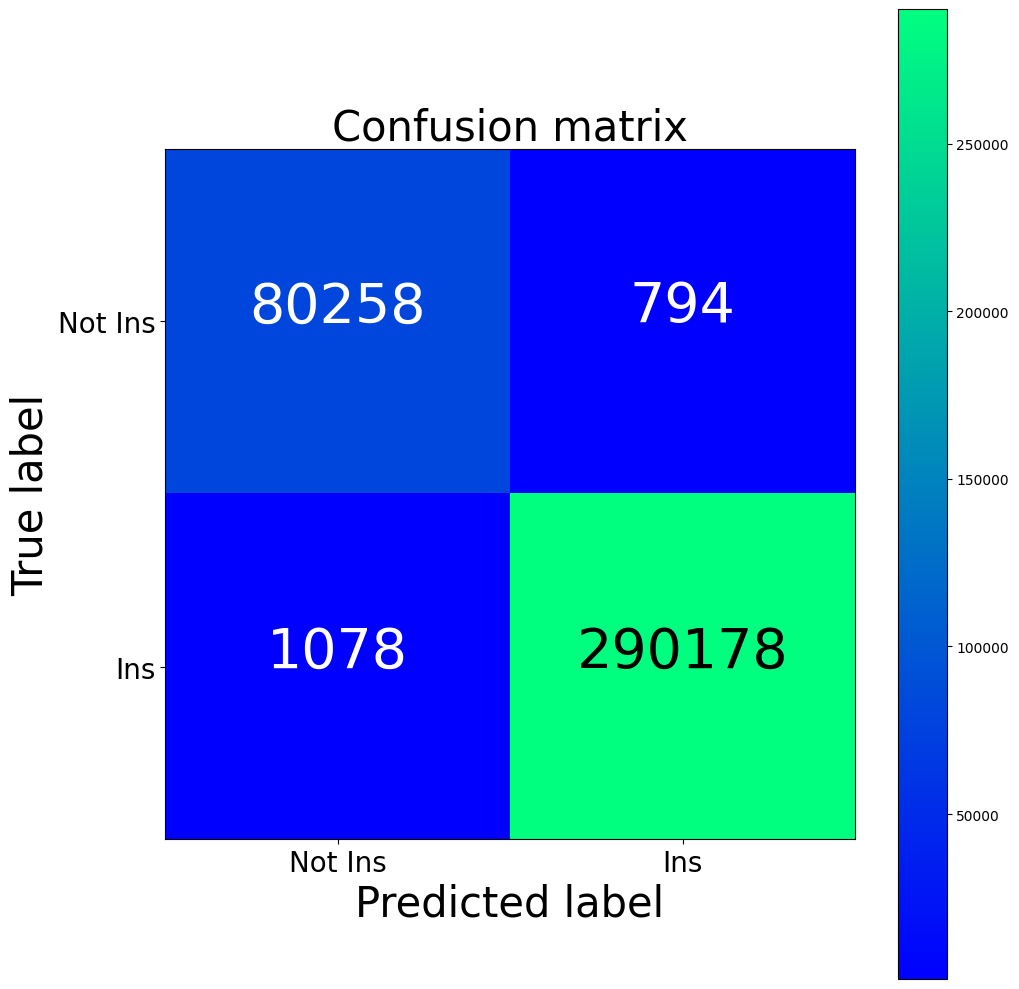

In [336]:
cm2 = confusion_matrix(df.select('target').toPandas(), df.select('pred').toPandas())
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Not Ins','Ins'], normalize=False, title='Confusion matrix')
plt.show()

In [153]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 150)

In [331]:
df_pandas = df.select('text', 'target', 'prediction', 'pred', 'probability').toPandas()

In [332]:
df_pandas['short'] = df_pandas.text.apply(lambda x: x[:20])

In [333]:
df_pandas = df_pandas.drop_duplicates(subset='short')

In [334]:
df_pandas[(df_pandas.target != df_pandas.pred) & (df_pandas.pred==0)].head(50)

text  \
26                                                          лс ооо деппа замечания при проверке страховки для расчета осаго просьба указать мощность тс в лк    
996                                                  пункт урегулирования убытков осаго стоа форсаж армавир ул ул шоссейная б по записи пн -пт с до суб с до    
1501                                                                                                    вам подготовлен полис осаго проверьте - ресо-гарантия   
2816                                            внимание срок осаго и то подходит к концу павловский тракт д д ост мастерские змеиногорский д плодовка тел -    
2839                                                                                      сожалеем по заявке на каско не готовы принять положительное решение   
2925                                                                              также мы предоставляем услуги по страхованию осаго каско автокредит лизинг    
2953     уважаемый алексей сергеевич напоминаем что вы записаны на сервис в ауди центр север на ваш мастер консультант птицын дмитрий адрес город москва л...   
9413     ликвидация автомобилей года только до декабря скидки до тысяч и каско в подарок официальный дилер - важная персона авто тверь московское шоссе зв...   
37128   наталья валерьевна для расторжения договора каско отправьте нам на почту или в чат заполненное и подписанное заявление шаблон заявления отправлен ...   
47165    заполненное извещение о дтп или номер электронного извещения о дтп птс или стс паспорт собственника тс нотариальная доверенность и паспорт заявит...   
47291    рустям джавдятович ожидаем вас по адресу мкад км д автосалон химки ваш специалист онегина валерия - - пакет документов паспорт рф водительское уд...   
49131                                                       до распродажа скидки кредит от персон предложение от руководителя шины каско и др подарки сатурн    
49631                                                                                    сканы по вашему заявлению е-осаго не приняты не совпадает модель тс    
50398    дмитрий александрович ожидаем вас по адресу мкад км д алея ваш специалист романова алина - - пакет документов паспорт рф водительское удостоверен...   
56456                                                              информация по расторжению полиса осаго отправлена вам на эл адрес пожалуйста ознакомьтесь    
57424                                        ольга николаевна купите полис каско-профи на млн р за р быстрый ремонт у дилера даже если у виновника нет осаго    
58041   уважаемый клиент информируем что ваше направление на ремонт по событию отправлено на стоа каско-пву г ленинский д - согласуйте время посещения сто...   
62154    уважаемая мерует сериковна ваше обращение рассмотрено сообщаем что предоставленный вами полис каско удовлетворяет требованиям банка ставка по ваш...   
62738               для расторжения договора осаго отправьте нам на почту или в чат документ подтверждающий смену собственника дкп и апп при наличии стс птс    
64246                                                                                   полис осаго с изменениями отправлен вам на - пожалуйста ознакомьтесь    
67642                                      игорь вячеславович купите полис каско-профи на млн р за р быстрый ремонт у дилера даже если у виновника нет осаго    
86623    справка о штатности сотрудника юридического лица заверенная копия трудовой книжки на водителя находящегося за рулем тс в момент сс требуется толь...   
97343    дмитрий васильевич добрый день это валерия автосалон максимум стоимость полиса каско угон тотал - р при стоимости авто - р каско только угон - р ...   
100252                                                                                                  ваш полис осаго истек но наше предложение еще в силе    
113673                                                                                                                акт о стра

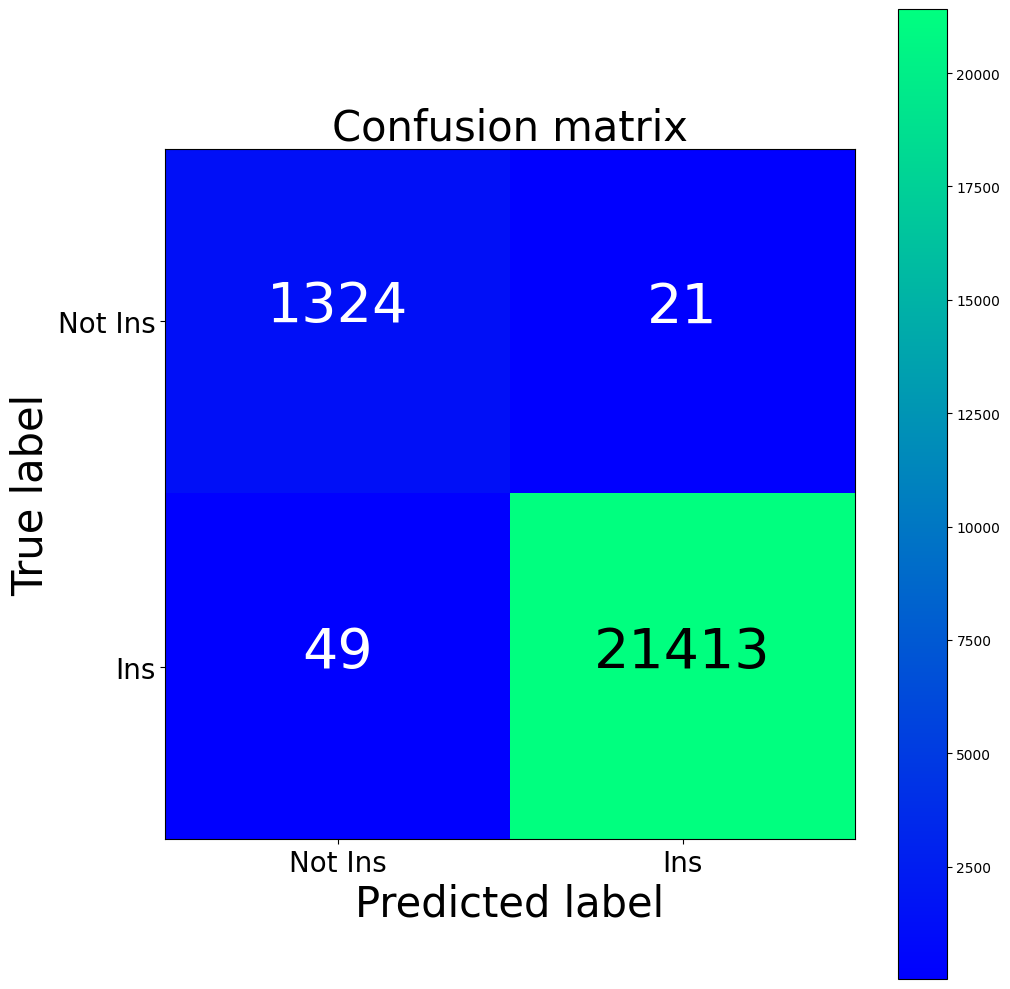

In [335]:
cm2 = confusion_matrix(df_pandas.target, df_pandas.pred)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Not Ins','Ins'], normalize=False, title='Confusion matrix')
plt.show()

In [134]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

In [18]:
spark.stop()